# Generate background pseudo-absence data

In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr

import geowombat as gw
from geowombat.data import rgbn
from geocube.api.core import make_geocube

import elapid as ela

import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader


In [2]:
projection = ccrs.PlateCarree()

def make_map(figsize, projection, res, ncols=None):
    
    if ncols == None:
        fig = plt.figure(figsize=figsize)
        axes = [plt.axes(projection=projection)]
    else:
        fig, axes = plt.subplots(figsize=figsize, ncols=ncols, subplot_kw={'projection': projection})
    
    for ax in axes:
        ax.add_feature(cfeature.BORDERS.with_scale(res)) # , color='gray'
        ax.add_feature(cfeature.STATES.with_scale(res),
                       linestyle=':', edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.LAND.with_scale(res), color='lightgray')
        ax.add_feature(cfeature.COASTLINE.with_scale(res))

        gl = ax.gridlines(color='grey', linestyle=':', draw_labels=True, rotate_labels=False) #ylocs=[-45, -60, -75])
    
    return fig, axes, gl

In [3]:
data_path = os.path.join(os.sep, 'scratch', 'aciar-fst', 'data')
out_path = os.path.join(os.sep, 'mnt', 'jmeijer_workspace', 'checkouts', 'aciar', 'out')
input_path = os.path.join(out_path, 'input')

In [4]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'thaumastocoris-peregrinus' #'leptocybe-invasa' # 
# region = 'australasia' #'east-asia'
training = 'australia'
interest = 'south-east-asia'
count = 1000

###########################################################

In [5]:
regions = {
    'east-asia': ['China', 'Taiwan', 'Japan', 'North Korea', 'South Korea'],
    'south-east-asia': ['Brunei', 'Myanmar', 'Cambodia', 'East Timor', 'Indonesia', 'Laos', 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam'],
    'australia': ['Australia']
}

## Load shapefiles of countries

In [6]:
# request data for use by geopandas
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
countries = gpd.read_file(shpfilename)

In [7]:
# select and combine countries in one dataframe
gdf_countries = {}
for region in [training, interest]:
    gdf_countries[region] = gpd.GeoDataFrame()

    for country in regions[region]:
        cntry = countries.loc[countries['ADMIN'] == country]
        gdf_countries[region] = pd.concat([gdf_countries[region], cntry])


In [8]:
shapes = [shape for shape in gdf_countries[interest].geometry]

## Load occurence data

In [9]:
occurences = {}
for region in [training, interest]:
    occurences_file_name = os.path.join(input_path, '%s_presence_%s.csv' %(specie, region))
    df = pd.read_csv(occurences_file_name)
    occurences[region] = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

## 1. Random

In [10]:
# generate randomly distributed background points
raster_file = os.path.join(input_path, 'srtm_%s.tif' %region)

pseudoabsence_random = ela.sample_raster(raster_file, count=count)

print('Number of presences in %s is: %s' %(region, len(occurences[interest])))
print('Number of random selected background points in %s is: %s' %(interest, len(pseudoabsence_random)))

Number of presences in south-east-asia is: 0
Number of random selected background points in south-east-asia is: 1000


In [11]:
# save background point to file
pseudoabsence_random = pseudoabsence_random.to_frame(name='geometry')
pseudoabsence_random['lon'] = pseudoabsence_random['geometry'].x
pseudoabsence_random['lat'] = pseudoabsence_random['geometry'].y
pseudoabsence_random.to_csv(os.path.join(input_path, '%s_background_random_%s.csv' %(specie, interest)), columns=['lon', 'lat'], index=False)

<GeoAxes: >

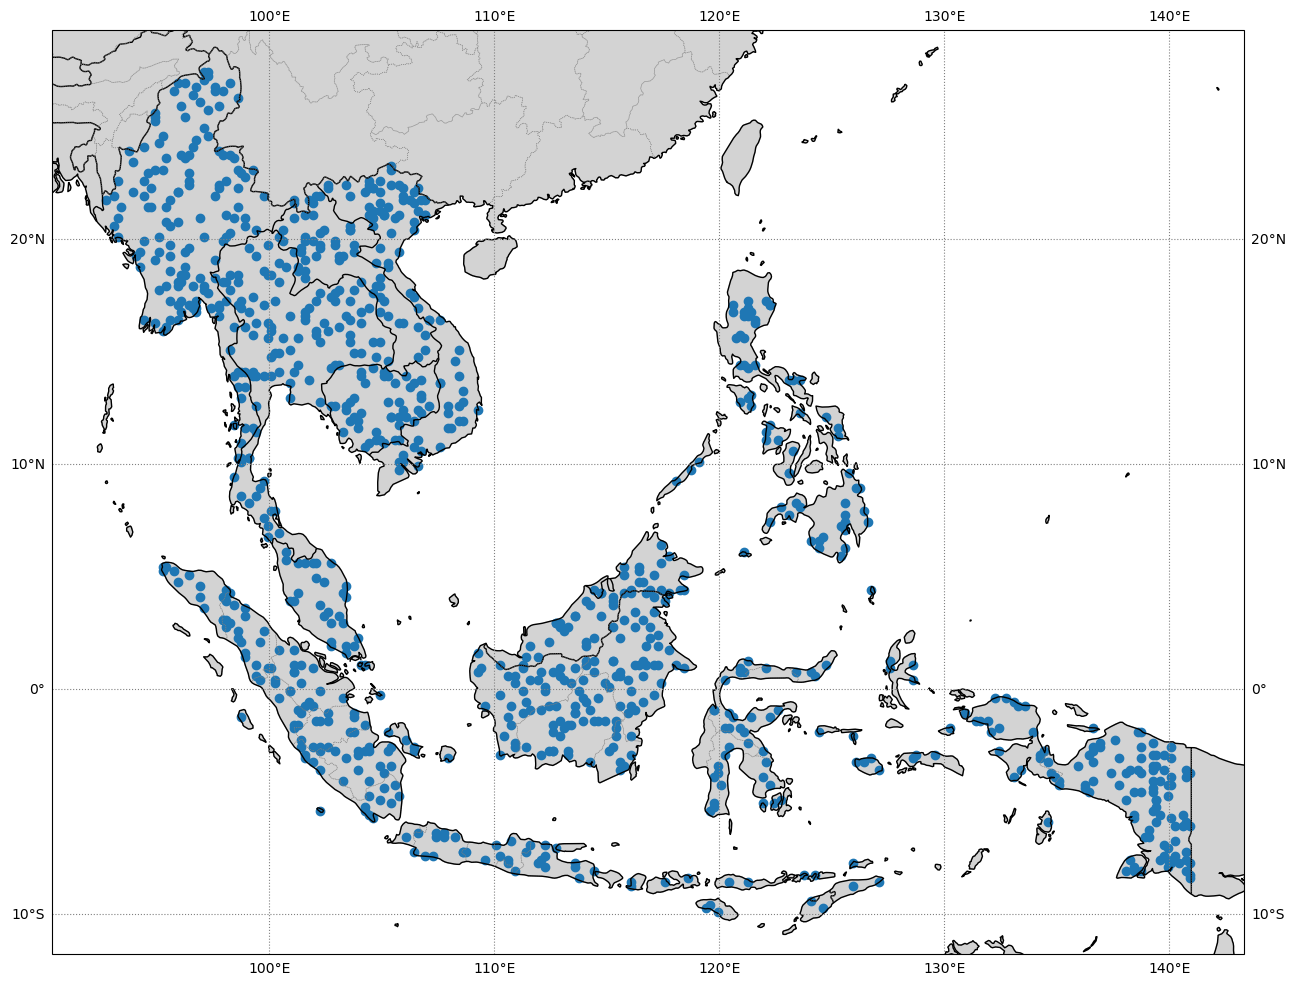

In [12]:
fig, axes, gl = make_map(figsize=(18,12), projection=projection, res=resolution)
ax = axes[0]
pseudoabsence_random.plot(ax=ax)
occurences[interest].plot(ax=ax, marker='*', markersize=100, color='tab:red')

## 2. Biased towards host specie

### 2.1 Biased towards Tree-Type based on Copernicus land cover dataset
https://land.copernicus.eu/global/products/lc


In [13]:
land_cover_box_file = os.path.join('temp', 'land-cover_box.tif')
land_cover_output_file = os.path.join(input_path, 'land-cover_%s.tif' %interest)
# if not os.path.isfile(land_cover_box_file):

land_cover_file = os.path.join(data_path, 'land-cover', 'PROBAV_LC100_global_v3.0.1_2019-nrt_Forest-Type-layer_EPSG-4326.tif')
land_cover_glo = rioxr.open_rasterio(land_cover_file, masked=True)
raster = rioxr.open_rasterio(raster_file, masked=True)

# subset global dataset
land_cover_box = land_cover_glo.rio.clip_box(
    minx=raster.x.min() - 1,
    miny=raster.y.min() - 1,
    maxx=raster.x.max() + 1,
    maxy=raster.y.max() + 1,
)

if not os.path.exists('temp'):
    os.makedirs('temp')
land_cover_box.rio.to_raster(land_cover_box_file)
land_cover_box.close()
land_cover_glo.close()

# 100m ~ 0.001 deg
# 1000m ~ 0.01 deg
ref_res = (0.01, 0.01)

with gw.config.update(ref_res=ref_res):
    with gw.open(land_cover_box_file, resampling="bilinear", nodata=255, chunks=1024) as src:
        data = src.isel(band=0).rio.clip(geometries=shapes)
        data.rio.to_raster(land_cover_output_file)


In [14]:
# load forest type from Copernicus Land Cover dataset
land_cover_region = rioxr.open_rasterio(land_cover_output_file, mask_and_scale=True)
land_cover_region = land_cover_region.isel(band=0)

In [15]:
# forest type land cover dataset
# indicate likelihood that specie occurs in Forest type with a number between 0 and 1
forest_dict = {
    0: ['N/K', 'Unknown', 0, 'white'],
    1: ['ENF', 'Evergreen Needleleaf Forest', 0.8, 'red'],
    2: ['EBF', 'Evergreen Broadleaf Forest', 1.0, 'orange'],
    3: ['DNF', 'Deciduous Needleleaf Forest', 0.2, 'green'],
    4: ['DBF', 'Deciduous Broadleaf Forest', 0.4, 'blue'],
    5: ['MF', 'Mixed Forest', 0.5, 'purple']}

In [16]:
# changes flag values to normalised and weighted 
land_cover_region_norm = land_cover_region.copy(deep=False)
values = land_cover_region_norm.values
# make raster based on likelihood values
for key, val in forest_dict.items():
    print(key, val[2])
    values[np.where(values == key)] = val[2]

0 0
1 0.8
2 1.0
3 0.2
4 0.4
5 0.5


In [17]:
# save biased raster to file
land_cover_bias_file_name = 'land-cover_biased_%s.tif' %interest
land_cover_region_norm.rio.to_raster(os.path.join(input_path, land_cover_bias_file_name))

In [18]:
pseudoabsence_bias_land_cover = ela.sample_bias_file(os.path.join(input_path, land_cover_bias_file_name), count=count)

print('Number of presences in %s is: %s' %(region, len(occurences[interest])))
print('Number of random selected background points in %s is: %s' %(interest, len(pseudoabsence_bias_land_cover)))

Number of presences in south-east-asia is: 0
Number of random selected background points in south-east-asia is: 1000


In [19]:
# save background points to file
pseudoabsence_bias_land_cover = pseudoabsence_bias_land_cover.to_frame(name='geometry')
pseudoabsence_bias_land_cover['lon'] = pseudoabsence_bias_land_cover['geometry'].x
pseudoabsence_bias_land_cover['lat'] = pseudoabsence_bias_land_cover['geometry'].y
pseudoabsence_bias_land_cover.to_csv(os.path.join(input_path, '%s_background_biased_land-cover_%s.csv' %(specie, interest)), columns=['lon', 'lat'], index=False)

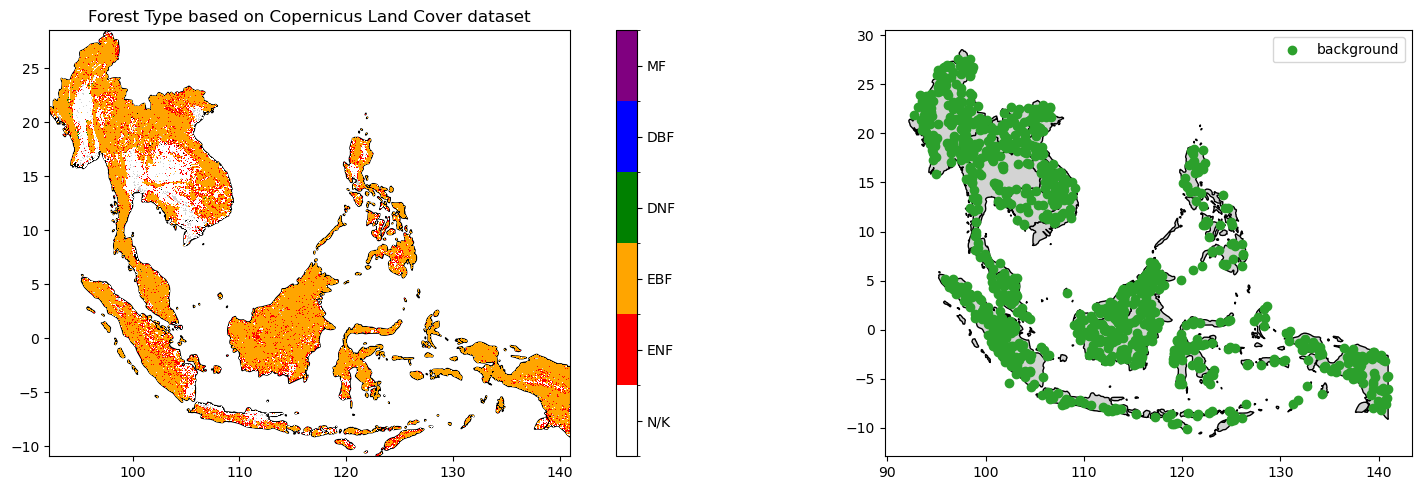

In [20]:
# fig, axes, gl = make_map(figsize=(18,6), projection=projection, res=resolution, ncols=2)
fig, axes = plt.subplots(figsize=(18,5), ncols=2)

labels = [forest_dict[x][0] for x in forest_dict.keys()]
legend = [forest_dict[x][1] for x in forest_dict.keys()]

cmap_lc = mpl.colors.ListedColormap([forest_dict[x][3] for x in forest_dict.keys()])
# cmap.set_bad('transparent')
norm_lc = mpl.colors.BoundaryNorm(np.arange(-0.5,6), cmap_lc.N) 
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm_lc(x)])

gdf_countries[interest].plot(ax=axes[0], facecolor='lightgray', edgecolor='k')
pcol = land_cover_region.plot(ax=axes[0], cmap=cmap_lc, norm=norm_lc, add_colorbar=False, add_labels=False)
plt.colorbar(pcol, format=fmt, ticks=np.linspace(0,5,6))
axes[0].set_title('Forest Type based on Copernicus Land Cover dataset')

gdf_countries[interest].plot(ax=axes[1], facecolor='lightgray', edgecolor='k')
pseudoabsence_bias_land_cover.plot(ax=axes[1], color='tab:green', label='background')
occurences[interest].plot(ax=axes[1], marker='*', markersize=100, color='tab:red', label='presence')
axes[1].legend()

plt.tight_layout()

### 2.2 Biased towards planted forest East Asia (Abbasi et al. 2023)
https://www.nature.com/articles/s41597-023-02383-w

In [21]:
region = 'east-asia'

In [22]:
forest_type_dict = {
    'Tropical Forest and Savanna': 0.8,
    'Temperate Forest': 0.4,
    'Eucalyptus': 1
}

In [23]:
forest_type_bias_file = os.path.join(input_path, 'forest-type_biased_%s.tif' %region)
if not os.path.isfile(forest_type_bias_file):
 
    planted_forest_file = os.path.join('zip://', data_path, 'species', 'planted-forest-east-asia', 'planted-forest-east-asia.zip')

    # planted_eucalyptus = gpd.read_file(planteplanted_forest_file, where="Genus='Eucalyptus'")
    tropical_forest = gpd.read_file(planted_forest_file, where="Biome='Tropical Forest and Savanna'", include_fields=['Biome', 'Genus', 'Type'])
    temperate_forest = gpd.read_file(planted_forest_file, where="Biome='Temperate Forest'", include_fields=['Biome', 'Genus', 'Type'])
    forest_type_region = pd.concat([tropical_forest, temperate_forest])


    # indicate likelihood that specie occurs in Genus or Biome type type with a number between 0 and 1
    # changes flag values to normalised and weighted
    forest_type_region['norm'] = 0
    for key, val in forest_type_dict.items():
        forest_type_region.loc[forest_type_region.Biome == key, 'norm'] = val
        if key == 'Eucalyptus':
            forest_type_region.loc[forest_type_region.Genus == key, 'norm'] = val
#         temperate_forest.loc[
#             temperate_forest['potential'] = 0.5
#             temperate_forest.loc[temperate_forest.Genus == 'Eucalyptus', 'potential'] = 1
#             tropical_forest['potential'] = 1
    
    # rasterize vector data
    forest_type_raster = make_geocube(
    vector_data=forest_type_region,
    measurements=['norm'],
    resolution=(0.01, -0.01),#0.0174532925199433
#     fill = 0
    )
    
    # save raster to file
    forest_type_raster.rio.to_raster(forest_type_bias_file)
else:
    forest_type_raster = rioxr.open_rasterio(forest_type_bias_file)
    
pseudoabsence_bias_forest = ela.sample_bias_file(forest_type_bias_file, count=count)

print('Number of presences in %s is: %s' %(region, len(occurences[region])))
print('Number of background points with a bias towards forests in %s is: %s' %(region, len(pseudoabsence_bias_forest)))

KeyError: 'east-asia'

In [ ]:
# save background points to file
pseudoabsence_bias_forest = pseudoabsence_bias_forest.to_frame(name='geometry')
pseudoabsence_bias_forest['lon'] = pseudoabsence_bias_forest['geometry'].x
pseudoabsence_bias_forest['lat'] = pseudoabsence_bias_forest['geometry'].y
pseudoabsence_bias_forest.to_csv(os.path.join(input_path, '%s_background_biased_forest-type_%s.csv' %(specie, region)), columns=['lon', 'lat'], index=False)

In [ ]:
# fig, axes, gl = make_map(figsize=(18,6), projection=projection, res=resolution, ncols=2)
fig, axes = plt.subplots(figsize=(18,5), ncols=2)

cmap_ft = mpl.colors.ListedColormap(['white', 'orange', 'green'])
cmap_ft.set_bad('k', alpha=0)
bounds=[0,.333,.667,1]
norm_ft = mpl.colors.BoundaryNorm(bounds, cmap_ft.N)

gdf_countries[region].plot(ax=axes[0], facecolor='lightgray', edgecolor='k')
try:
    pcol = forest_type_raster.norm.plot(ax=axes[0], cmap=cmap_ft, norm=norm_ft, add_colorbar=False, add_labels=False)
except AttributeError:
    pcol = forest_type_raster.plot(ax=axes[0], cmap=cmap_ft, norm=norm_ft, add_colorbar=False, add_labels=False)

plt.colorbar(pcol)
axes[0].set_title('Forest Type normalised and weighted, based on Abbasi et al. 2023')
axes[0].set_xlim(72, 146)
    
gdf_countries[region].plot(ax=axes[1], facecolor='lightgray', edgecolor='k')
pseudoabsence_bias_forest.plot(ax=axes[1], color='tab:green', label='background')
occurences[region].plot(ax=axes[1], marker='*', markersize=100, color='tab:red', label='presence')
axes[1].legend()

plt.tight_layout()